# CNN Fashion MNIST Mini Project
- Fashion MNIST:
    - 10 classes
    - 60000 training images
    - 10000 testing images

## 1. Prepare the data:
- E = Extract - Get Fashion MNIST image data from the source
- T = Transform - Put data to tensor form
- L = Load - Put data to object for easier accessed

In [1]:
import torch
import torchvision  
import torchvision.transforms as transforms # image transformation

In [2]:
train_set = torchvision.datasets.FashionMNIST(
    root = './data/FashionMNIST', # directory to be download
    train = True, # trainable dataset
    download = True, # Download to local machine
    transform = transforms.Compose([ # Convert images into Tensor Transformation
        transforms.ToTensor()
    ])
)

In [3]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size = 10) # can have shuffle and batchsize

# This allow us to query of the dataset

### Better understand the dataset

In [4]:
import numpy as np
import matplotlib.pyplot as plt

torch.set_printoptions(linewidth=120)

In [5]:
len(train_set)

60000

In [6]:
# Check number of labels
train_set.train_labels

C:\Users\nguye\anaconda3\lib\site-packages\torchvision\datasets\mnist.py:54: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


tensor([9, 0, 0,  ..., 3, 0, 5])

In [7]:
# Check number of images in each class
train_set.train_labels.bincount()

tensor([6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000])

torch.Size([1, 28, 28])
9
label: 9


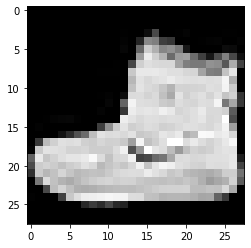

In [8]:
# Check elements in a train set
sample_input = next(iter(train_set))
tuple(sample_input)
image, label = sample_input

print(image.shape)
print(label)
plt.imshow(image.squeeze(), cmap="gray")
print(f"label: {label}")

In [9]:
# Analyse the batch
batch = next(iter(train_loader))
images, labels = batch

In [10]:
images.shape

torch.Size([10, 1, 28, 28])

In [11]:
labels.shape

torch.Size([10])

tensor([9, 0, 0, 3, 0, 2, 7, 2, 5, 5])


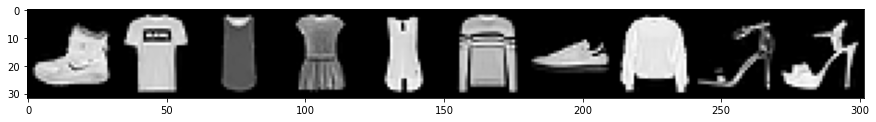

In [12]:
grid = torchvision.utils.make_grid(images, nrow=10)
plt.figure(figsize=(15,15))
plt.imshow(np.transpose(grid, (1,2,0)))
print(labels)

## 2. Build model
- Methods = Function
- Attributes = Representation of the data
- Parameters vs Arguments: 
    - parameters = local to the funciton
    - argument = values assigned to parameters by the caller of the function
    => Parameter is in_channels, arguments = 1, 6, 12....
 
- kernel_size = set of filter size
- out_channels = set of number of filters => This can be called as feature maps
- out_features = set of size of output tensor

In [13]:
import torch.nn as nn
import torch.nn.functional as F

In [14]:
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        # Convolutional layers
        
        # NOTE param: color channel of image, number of filter, size of kernel, stride
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1) # in_channel = 1 = grayscale, hyperparam, hyperparam
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=5, stride=1) # we in crease the output channel when have extra conv layers
        
        # Why the out channel = 6 or why the in_features is 12*4*4 => flatten. 4x4?
        
        # Fully connected layers
        self.fc1 = nn.Linear(in_features=12*4*4, out_features=120, bias=True) # we also shrink the number of features to number of class that we have
        self.fc2 = nn.Linear(in_features = 120, out_features=60, bias=True)
        self.out = nn.Linear(in_features = 60, out_features=10, bias=True) 
        
    def forward(self, t):
        # input layer
        t = t
        print(f"TESTING: {t.shape}")
        
        # convolution 1, not 
        t = self.conv1(t)
        t = F.relu(t) # operation do not use weight, unlike layers
        t = F.max_pool2d(t, kernel_size=2, stride=2) # operation do not use weight, unlike layers
        
        # convolution 2: => relu => maxpool
        t = self.conv2(t)
        # WHY do we need these 2 layers?
        t = F.relu(t) 
        t = F.max_pool2d(t, kernel_size=2, stride=2) # how to determine these values?
        
        # Transition from Conv to Linear will require flatten
        t = t.reshape(-1, 12*4*4) # 4x4 = shape of reduce image (originally 28x28)
        
        # linear 1:
        t = self.fc1(t)
        t = F.relu(t)
        
        # linear 2:
        t = self.fc2(t)
        t = F.relu(t)
        
        # output:
        t = self.out(t)
#       t = F.softmax(t, dim=1) # we will use crossentropy loss which used the softmax already
        
        return t
        

In [15]:
network = Network()
print(network)

Network(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 12, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=192, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=60, bias=True)
  (out): Linear(in_features=60, out_features=10, bias=True)
)


In [16]:
# Analyze the layer weight
print(network.conv1.weight.shape) # (out, in, kernel - height&width of filter)
print(network.conv2.weight.shape) # (out, in, kernel)
print(network.fc1.weight.shape) # (out, in)
print(network.fc2.weight.shape) # (out, in)
print(network.out.weight.shape) # (out, in)

torch.Size([6, 1, 5, 5])
torch.Size([12, 6, 5, 5])
torch.Size([120, 192])
torch.Size([60, 120])
torch.Size([10, 60])


In [17]:
for name, param in network.named_parameters():
    print(f"{name} \t\t {param.shape}")

conv1.weight 		 torch.Size([6, 1, 5, 5])
conv1.bias 		 torch.Size([6])
conv2.weight 		 torch.Size([12, 6, 5, 5])
conv2.bias 		 torch.Size([12])
fc1.weight 		 torch.Size([120, 192])
fc1.bias 		 torch.Size([120])
fc2.weight 		 torch.Size([60, 120])
fc2.bias 		 torch.Size([60])
out.weight 		 torch.Size([10, 60])
out.bias 		 torch.Size([10])


### Understanding Linear Layer

In [18]:
in_features = torch.tensor([1,2,3,4], dtype=torch.float32)

fc = nn.Linear(in_features=4, out_features=3)

matmul_fc = fc(in_features)
print(f"The matrix multiplication answer is {matmul_fc}")

The matrix multiplication answer is tensor([0.7207, 1.8323, 1.8387], grad_fn=<AddBackward0>)


### Forward Propagation

In [19]:
# turn an image into a batch to feed in the NN
image.unsqueeze(0).shape

torch.Size([1, 1, 28, 28])

In [20]:
pred = network(image.unsqueeze(0)) # we put in the param for the forward function

TESTING: torch.Size([1, 1, 28, 28])


In [21]:
pred.shape # 1 image in a batch & 10 prediction

torch.Size([1, 10])

In [22]:
print(pred.argmax(dim=1))

tensor([5])


In [23]:
label # prediction is incorrect compared to the ground truth

9

### Forward Propagation with Batch

In [24]:
data_loader = torch.utils.data.DataLoader(
    train_set, batch_size=10
) # this is an iteratro

In [25]:
batch = next(iter(data_loader))

In [26]:
images, labels = batch

In [27]:
print(images.shape)
print(labels.shape)

torch.Size([10, 1, 28, 28])
torch.Size([10])


In [28]:
preds = network(images)

TESTING: torch.Size([10, 1, 28, 28])


In [29]:
print(preds) 
# we can understand this as 10 predictions (out_channels) of prediction, use softmax or max_arg to provide the most prediction

tensor([[-0.0911,  0.0854,  0.0196,  0.0619, -0.0486,  0.1152, -0.1129,  0.0421, -0.0517, -0.0074],
        [-0.0859,  0.0913,  0.0144,  0.0642, -0.0479,  0.1092, -0.1145,  0.0461, -0.0506, -0.0031],
        [-0.0935,  0.0778,  0.0275,  0.0584, -0.0541,  0.1161, -0.1104,  0.0351, -0.0505, -0.0061],
        [-0.0932,  0.0801,  0.0238,  0.0594, -0.0523,  0.1168, -0.1112,  0.0385, -0.0505, -0.0052],
        [-0.0876,  0.0871,  0.0162,  0.0599, -0.0538,  0.1152, -0.1140,  0.0488, -0.0543, -0.0058],
        [-0.0894,  0.0843,  0.0197,  0.0623, -0.0471,  0.1156, -0.1117,  0.0410, -0.0500, -0.0058],
        [-0.0924,  0.0803,  0.0179,  0.0621, -0.0485,  0.1189, -0.1111,  0.0353, -0.0507, -0.0043],
        [-0.0889,  0.0832,  0.0159,  0.0625, -0.0475,  0.1192, -0.1104,  0.0427, -0.0475, -0.0059],
        [-0.0995,  0.0725,  0.0246,  0.0572, -0.0509,  0.1183, -0.1036,  0.0301, -0.0517, -0.0081],
        [-0.1010,  0.0778,  0.0190,  0.0598, -0.0499,  0.1175, -0.1103,  0.0371, -0.0520, -0.0109]],

In [30]:
preds.argmax(dim=1)

tensor([5, 5, 5, 5, 5, 5, 5, 5, 5, 5])

In [31]:
labels

tensor([9, 0, 0, 3, 0, 2, 7, 2, 5, 5])

In [32]:
# Calculate the correct labels compared with the prediction
def compare(preds, labels):
    """Provides totals number of correct prediction
    
    Parameters
    ----------
    preds:
        list of prediction
    labels:
        list of ground truths
    """
    result = preds.argmax(dim=1).eq(labels).sum()
    
    return result

print(compare(preds, labels))

tensor(2)


## 3. The Training Process:
- 1. Get batch from the training set
- 2. Pass batch to the network
- 3. Calculate the loss (difference betwee the predicted values and the true values) - LOSS FUNCTION
- 4. Calcualte the gradient of the loss function wrt the netowork's weights - BACK PROP
- 5. Update the weights using the gradients to reduce the loss - OPTIMIZATION ALGO
- 6. Repeat steps 1-5 until one epoch is completed
- 7. Repeat steps 1-6 for as many epochs required to obtain the desired level of accuracy

=> 1 epochs = complete pass thru all samples of the training dataset

In [33]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

torch.set_printoptions(linewidth=120)

In [34]:
def get_num_correct(preds, labels):
    return preds.argmax(dim=1).eq(labels).sum().item()

In [35]:
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        # Convolutional layers
        
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1) # in_channel = 1 = grayscale, hyperparam, hyperparam
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=5, stride=1) # we in crease the output channel when have extra conv layers
                
        # Fully connected layers
        self.fc1 = nn.Linear(in_features=12*4*4, out_features=120, bias=True) # we also shrink the number of features to number of class that we have
        self.fc2 = nn.Linear(in_features = 120, out_features=60, bias=True)
        self.out = nn.Linear(in_features = 60, out_features=10, bias=True) 
        
    def forward(self, t):
        # input layer
        t = t
        
        # convolution 1, not 
        t = self.conv1(t)
        t = F.relu(t) # operation do not use weight, unlike layers
        t = F.max_pool2d(t, kernel_size=2, stride=2) # operation do not use weight, unlike layers
        
        # convolution 2: => relu => maxpool
        t = self.conv2(t)
        # WHY do we need these 2 layers?
        t = F.relu(t) 
        t = F.max_pool2d(t, kernel_size=2, stride=2) # how to determine these values?
        
        # Transition from Conv to Linear will require flatten
        t = t.reshape(-1, 12*4*4) # 4x4 = shape of reduce image (originally 28x28)
        
        # linear 1:
        t = self.fc1(t)
        t = F.relu(t)
        
        # linear 2:
        t = self.fc2(t)
        t = F.relu(t)
        
        # output:
        t = self.out(t)
        
        return t

In [36]:
train_set = torchvision.datasets.FashionMNIST(
    root="./data/FashionMNIST",
    train=True,
    download=True,
    transform=transforms.Compose([ # convert image to 
        transforms.ToTensor()
    ]))

In [37]:
network = Network()

In [38]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size = 100) # pass the training set and divide into batch of 100
batch = next(iter(train_loader)) # get a sample batch
images, labels = batch

### Calcualting the Loss

In [39]:
preds = network(images) # pass the batch of image thru the network
loss = F.cross_entropy(preds, labels) # calculate the loss
loss.item() # get the loss

# item() contains the loss of entire mini-batch, but divided by the batch size.
# Goal: we want the loss to be decrease

2.3089168071746826

### Calculating the Gradients. Back Prop

In [40]:
print(network.conv1.weight.grad)

None


In [41]:
loss.backward() # calculate the graident

In [42]:
print(network.conv1.weight.grad)
print(network.conv1.weight.grad.shape)

tensor([[[[ 4.6323e-04,  1.4078e-03,  8.0984e-04,  5.5834e-04,  1.9952e-03],
          [ 7.8312e-04,  1.6110e-03,  1.3740e-03,  1.2380e-03,  2.7021e-03],
          [ 1.2505e-03,  1.7090e-03,  1.0253e-03,  1.1032e-03,  2.6810e-03],
          [ 6.2296e-04,  1.3367e-03,  1.1384e-03,  1.6654e-03,  2.5975e-03],
          [ 4.3458e-04,  1.5364e-03,  1.6356e-03,  2.4002e-03,  2.9890e-03]]],


        [[[-1.8531e-03, -2.3051e-03, -3.4586e-03, -3.1435e-03, -2.5931e-03],
          [-2.1732e-03, -2.8829e-03, -4.0729e-03, -3.3431e-03, -2.9297e-03],
          [-3.1861e-03, -3.6186e-03, -3.7462e-03, -3.0499e-03, -2.5995e-03],
          [-3.5344e-03, -3.3483e-03, -4.0562e-03, -3.5834e-03, -2.7679e-03],
          [-2.7358e-03, -3.2995e-03, -3.4873e-03, -2.8166e-03, -2.0110e-03]]],


        [[[-3.0482e-04, -2.1922e-04,  5.3109e-04,  2.7711e-04, -2.8756e-05],
          [-6.9535e-04, -1.7091e-04,  5.7366e-04, -7.5365e-05, -6.1022e-04],
          [-5.4535e-04,  1.5849e-04,  5.3918e-04, -9.2436e-05, -3.89

### Updating the networks' weights with optimizer

In [43]:
optimizer = optim.Adam(network.parameters(), lr=0.01) #initialize optimier

In [44]:
loss.item() # just to see the current loss without training

2.3089168071746826

In [45]:
get_num_correct(preds,labels) # just to see correct prediction without training

13

In [46]:
optimizer.step() # updates the weight

In [47]:
preds = network(images)
loss = F.cross_entropy(preds, labels)

In [48]:
loss.item()

2.2807466983795166

In [49]:
get_num_correct(preds, labels)

11

### Wrap up training in a single batch

In [50]:
network = Network()

train_loader = torch.utils.data.DataLoader(train_set, batch_size = 100)
optimizer = optim.Adam(network.parameters(), lr=0.01)

batch = next(iter(train_loader)) # get batch
images, labels = batch

preds = network(images)
loss = F.cross_entropy(preds, labels) # calculate loss

loss.backward() # calculate gradient/ backprop. Note, this does not affect the loss but just the learning hyperparam
optimizer.step() # Update the weight

############################################
print(f"Loss 2 step optimizer (update) {loss.item()}") # loss before training
preds = network(images)
loss = F.cross_entropy(preds, labels) # calculate loss
print(f"Loss 3 step optimizer (update) {loss.item()}") # loss after training


Loss 2 step optimizer (update) 2.291348695755005
Loss 3 step optimizer (update) 2.2746458053588867


### A Full Training Loop for all batch & multiple epochs

In [51]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

torch.set_printoptions(linewidth=120)

In [52]:
def get_num_correct(preds, labels):
    return preds.argmax(dim=1).eq(labels).sum().item()

In [53]:
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        # Convolutional layers
        
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1) # in_channel = 1 = grayscale, hyperparam, hyperparam
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=5, stride=1) # we in crease the output channel when have extra conv layers
                
        # Fully connected layers
        self.fc1 = nn.Linear(in_features=12*4*4, out_features=120, bias=True) # we also shrink the number of features to number of class that we have
        self.fc2 = nn.Linear(in_features = 120, out_features=60, bias=True)
        self.out = nn.Linear(in_features = 60, out_features=10, bias=True) 
        
    def forward(self, t):
        # input layer
        t = t
        
        # convolution 1, not 
        t = self.conv1(t)
        t = F.relu(t) # operation do not use weight, unlike layers
        t = F.max_pool2d(t, kernel_size=2, stride=2) # operation do not use weight, unlike layers
        
        # convolution 2: => relu => maxpool
        t = self.conv2(t)
        # WHY do we need these 2 layers?
        t = F.relu(t) 
        t = F.max_pool2d(t, kernel_size=2, stride=2) # how to determine these values?
        
        # Transition from Conv to Linear will require flatten
        t = t.reshape(-1, 12*4*4) # 4x4 = shape of reduce image (originally 28x28)
        
        # linear 1:
        t = self.fc1(t)
        t = F.relu(t)
        
        # linear 2:
        t = self.fc2(t)
        t = F.relu(t)
        
        # output:
        t = self.out(t)
        
        return t

In [54]:
train_set = torchvision.datasets.FashionMNIST(
    root="./data/FashionMNIST",
    train=True,
    download=True,
    transform=transforms.Compose([ # convert image to 
        transforms.ToTensor()
    ]))

In [55]:
network = Network()

train_loader = torch.utils.data.DataLoader(train_set, batch_size = 100)
optimizer = optim.Adam(network.parameters(), lr=0.01)

for epoch in range(5):

    total_loss = 0
    total_correct = 0

    for i, batch in enumerate(train_loader):
    #     print(f"Batch {i}")
        images, labels = batch

        preds = network(images)
        loss = F.cross_entropy(preds, labels) # calculate loss

        # Each weight has the corresponsing Gradient
        # before we calculate a new gradient for the same weight via each batch we have to zero out the gradient.
        # we want to use the new calculated gradient to update the weight. 

        optimizer.zero_grad() 
        loss.backward() # calculate gradient/ backprop. Note, this does not affect the loss but just the learning hyperparam
        optimizer.step() # Update the weight

        total_loss += loss.item()
        total_correct += get_num_correct(preds, labels)

    print(f"epoch: {epoch}, total_correct: {total_correct}, loss: {total_loss}")

epoch: 0, total_correct: 47859, loss: 325.8240841627121
epoch: 1, total_correct: 51775, loss: 226.27133131027222
epoch: 2, total_correct: 52480, loss: 205.96931199729443
epoch: 3, total_correct: 52738, loss: 198.12887558341026
epoch: 4, total_correct: 53023, loss: 190.52423013746738


In [56]:
print(f"The accuracy rate is {total_correct / len(train_set)}") # total correct of the latest trained model

The accuracy rate is 0.8837166666666667


### Confusion Matrix - Analyze CNN Results, building & Plotting a Confusion Matrix
- Which prediction classes confuse the network

In [57]:
print(len(train_set))
print(len(train_set.targets))

60000
60000


In [58]:
# Getting predictions for entire training set
def get_all_preds(model, data_loader): # data_loader for batches, model = trained model
    all_preds = torch.tensor([])
    for batch in data_loader:
        images, labels = batch
        
        preds = model(images)
        all_preds = torch.cat((all_preds, preds), dim=0)
    return all_preds

In [59]:
# when doing test prediction, we don't want tracking  the gradient
with torch.no_grad():
    prediction_loader = torch.utils.data.DataLoader(train_set, batch_size = 10000)
    train_preds = get_all_preds(network, prediction_loader)

In [60]:
train_preds.shape

torch.Size([60000, 10])

In [61]:
preds_correct = get_num_correct(train_preds, train_set.targets) # prediction, labels
print(f"accuracy: {preds_correct/len(train_set)}")

accuracy: 0.8715666666666667


#### Build a confusion matrix

In [62]:
#labels
train_set.targets

tensor([9, 0, 0,  ..., 3, 0, 5])

In [63]:
# Prediction
train_preds.argmax(dim=1)

tensor([9, 0, 3,  ..., 3, 0, 5])

In [64]:
# pair each labels & the prediction
stacked = torch.stack(
    (
        train_set.targets, train_preds.argmax(dim=1)
    ), dim = 1 # dim = 1 to pair up one by one
)

In [65]:
print(stacked.shape)

torch.Size([60000, 2])


In [66]:
stacked

tensor([[9, 9],
        [0, 0],
        [0, 3],
        ...,
        [3, 3],
        [0, 0],
        [5, 5]])

In [67]:
stacked[0].tolist()

[9, 9]

In [68]:
confusion_matrix = torch.zeros(10,10, dtype=torch.int64)
confusion_matrix

tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [69]:
for pair in stacked: 
    # for each pair of prediction (does not have to be in order), just add 1 to where you predict it
    labels, preds = pair.tolist()
    confusion_matrix[labels, preds] = confusion_matrix[labels, preds] + 1

In [70]:
confusion_matrix

tensor([[5089,   14,   80,  235,   12,   13,  508,    0,   49,    0],
        [   9, 5755,    3,  208,    2,   14,    2,    0,    7,    0],
        [  98,    8, 4614,  144,  769,   10,  309,    0,   48,    0],
        [ 137,   24,    8, 5651,  120,    0,   45,    0,   15,    0],
        [  13,   31,  361,  395, 4615,    3,  517,    0,   65,    0],
        [   1,    0,    0,    5,    0, 5859,    0,   81,    5,   49],
        [1063,   19,  640,  288,  445,    9, 3471,    0,   65,    0],
        [   0,    0,    0,    0,    0,  133,    0, 5703,    4,  160],
        [  17,    3,   54,   29,   10,   39,   30,   14, 5803,    1],
        [   0,    0,    1,    6,    0,   41,    0,  214,    4, 5734]])

#### Plot the confusion matrix

In [71]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
def plot_confusion_matrix(cm, classes, normalize = False, title="Confusion Matrix", cmap=plt.cm.Blues):
    """Prints and plots the confusion matrix
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np,newaxis]
        print("Normalized confusion matrix")
    else:
        print("Unnormalized confusion matrix")
    print(cm)
    
    plt.imshow(cm, interpolation="nearest", cmap = cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    fmt = ".2f" if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                horizontalalignment = "center",
                color = "white" if cm[i,j] > thresh else "black")
        
    plt.tight_layout()
    plt.ylabel("True labels")
    plt.xlabel("Prediction")

In [72]:
from sklearn.metrics import confusion_matrix


In [73]:
cm = confusion_matrix(train_set.targets, train_preds.argmax(dim=1))
print(type(cm))
cm

<class 'numpy.ndarray'>


array([[5089,   14,   80,  235,   12,   13,  508,    0,   49,    0],
       [   9, 5755,    3,  208,    2,   14,    2,    0,    7,    0],
       [  98,    8, 4614,  144,  769,   10,  309,    0,   48,    0],
       [ 137,   24,    8, 5651,  120,    0,   45,    0,   15,    0],
       [  13,   31,  361,  395, 4615,    3,  517,    0,   65,    0],
       [   1,    0,    0,    5,    0, 5859,    0,   81,    5,   49],
       [1063,   19,  640,  288,  445,    9, 3471,    0,   65,    0],
       [   0,    0,    0,    0,    0,  133,    0, 5703,    4,  160],
       [  17,    3,   54,   29,   10,   39,   30,   14, 5803,    1],
       [   0,    0,    1,    6,    0,   41,    0,  214,    4, 5734]],
      dtype=int64)

Unnormalized confusion matrix
[[5089   14   80  235   12   13  508    0   49    0]
 [   9 5755    3  208    2   14    2    0    7    0]
 [  98    8 4614  144  769   10  309    0   48    0]
 [ 137   24    8 5651  120    0   45    0   15    0]
 [  13   31  361  395 4615    3  517    0   65    0]
 [   1    0    0    5    0 5859    0   81    5   49]
 [1063   19  640  288  445    9 3471    0   65    0]
 [   0    0    0    0    0  133    0 5703    4  160]
 [  17    3   54   29   10   39   30   14 5803    1]
 [   0    0    1    6    0   41    0  214    4 5734]]


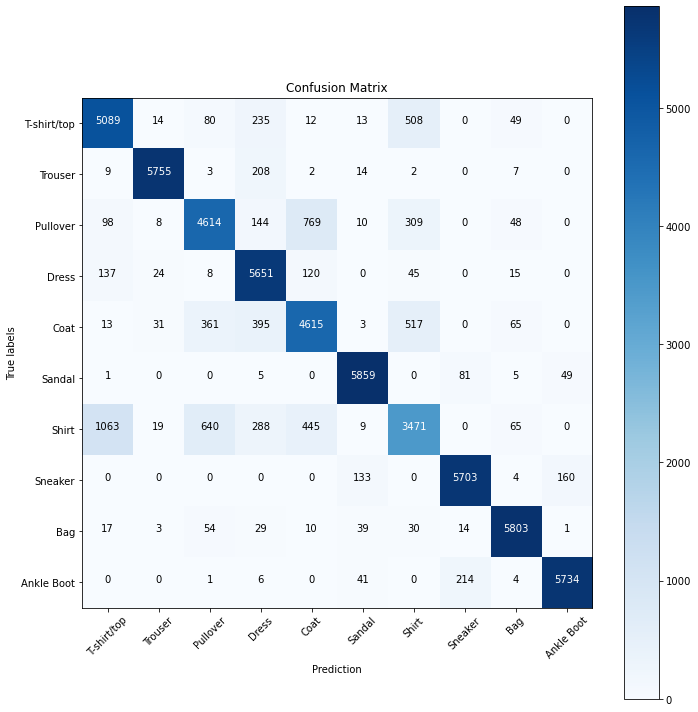

In [74]:
names = ("T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle Boot")
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, names)

### Concatenating vs Stacking
- Concatenating = Joins a sequence of tensors along an existing axis
- Stacking = Joins a sequence of tensors along a new axis

# Using TensorBoard-----------------------------------------------------------------------

In [75]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

torch.set_printoptions(linewidth=120)
torch.set_grad_enabled(True)

from torch.utils.tensorboard import SummaryWriter

In [76]:
def get_num_correct(preds, labels):
    return preds.argmax(dim=1).eq(labels).sum().item()

In [77]:
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        # Convolutional layers
        
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1) # in_channel = 1 = grayscale, hyperparam, hyperparam
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=5, stride=1) # we in crease the output channel when have extra conv layers
                
        # Fully connected layers
        self.fc1 = nn.Linear(in_features=12*4*4, out_features=120, bias=True) # we also shrink the number of features to number of class that we have
        self.fc2 = nn.Linear(in_features = 120, out_features=60, bias=True)
        self.out = nn.Linear(in_features = 60, out_features=10, bias=True) 
        
    def forward(self, t):
        # input layer
        t = t
        
        # convolution 1, not 
        t = self.conv1(t)
        t = F.relu(t) # operation do not use weight, unlike layers
        t = F.max_pool2d(t, kernel_size=2, stride=2) # operation do not use weight, unlike layers
        
        # convolution 2: => relu => maxpool
        t = self.conv2(t)
        # WHY do we need these 2 layers?
        t = F.relu(t) 
        t = F.max_pool2d(t, kernel_size=2, stride=2) # how to determine these values?
        
        # Transition from Conv to Linear will require flatten
        t = t.reshape(-1, 12*4*4) # 4x4 = shape of reduce image (originally 28x28)
        
        # linear 1:
        t = self.fc1(t)
        t = F.relu(t)
        
        # linear 2:
        t = self.fc2(t)
        t = F.relu(t)
        
        # output:
        t = self.out(t)
        
        return t

In [78]:
train_set = torchvision.datasets.FashionMNIST(
    root="./data/FashionMNIST",
    train=True,
    download=True,
    transform=transforms.Compose([ # convert image to 
        transforms.ToTensor()
    ]))

### Adding TB to dataset and network

In [79]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size = 100, shuffle=True)
tb = SummaryWriter()

network = Network()
images, labels = next(iter(train_loader))
grid = torchvision.utils.make_grid(images) # Create a grid to hold images

tb.add_image("images", grid)
tb.add_graph(network, images)
tb.close()

### Adding TB to the training loop

In [80]:
network = Network()
train_loader = torch.utils.data.DataLoader(train_set, batch_size = 100, shuffle = True)
optimizer = optim.Adam(network.parameters(), lr=0.01)

# For batch dataset + model analysis
tb = SummaryWriter()

images, labels = next(iter(train_loader))
grid = torchvision.utils.make_grid(images) # Create a grid to hold images

tb.add_image("images", grid)
tb.add_graph(network, images)

# For training process analysis
for epoch in range(10):

    total_loss = 0
    total_correct = 0

    for batch in train_loader:
        images, labels = batch

        preds = network(images)
        loss = F.cross_entropy(preds, labels) # calculate loss

        optimizer.zero_grad() 
        loss.backward() # calculate gradient/ backprop. Note, this does not affect the loss but just the learning hyperparam
        optimizer.step() # Update the weight5

        total_loss += loss.item()
        total_correct += get_num_correct(preds, labels)

    tb.add_scalar("Loss", total_loss, epoch)
    tb.add_scalar("Number Correct", total_correct, epoch)
    tb.add_scalar("Accuracy", total_correct / len(train_set), epoch)
    
    tb.add_histogram("conv1.bias", network.conv1.bias, epoch)
    tb.add_histogram("conv1.weight", network.conv1.weight, epoch)
    tb.add_histogram("conv1.weight.grad", network.conv1.weight.grad, epoch)
        
    print(f"epoch: {epoch}, total_correct: {total_correct}, loss: {total_loss}")

tb.close()

epoch: 0, total_correct: 47578, loss: 330.02903857827187
epoch: 1, total_correct: 51653, loss: 228.3071929216385
epoch: 2, total_correct: 52057, loss: 213.3909364193678
epoch: 3, total_correct: 52444, loss: 201.3433803766966
epoch: 4, total_correct: 52873, loss: 191.35578165203333
epoch: 5, total_correct: 52957, loss: 189.49972957372665
epoch: 6, total_correct: 53161, loss: 182.23613695800304
epoch: 7, total_correct: 53254, loss: 182.96793319284916
epoch: 8, total_correct: 53325, loss: 180.26875261217356
epoch: 9, total_correct: 53653, loss: 171.32632698118687


# Hyperparameter Tuning & Experienting

In [82]:
from itertools import product

In [83]:
parameters = dict(
    lr = [0.01, 0.001],
    batch_size = [10,100,1000],
    shuffle = [True, False]
)

In [84]:
param_values = [v for v in parameters.values()]
param_values

[[0.01, 0.001], [10, 100, 1000], [True, False]]

In [85]:
# This alternative for the 2 for loop for all combination
for lr, batch_size, shuffle in product(*param_values):
    print(lr, batch_size, shuffle)

0.01 10 True
0.01 10 False
0.01 100 True
0.01 100 False
0.01 1000 True
0.01 1000 False
0.001 10 True
0.001 10 False
0.001 100 True
0.001 100 False
0.001 1000 True
0.001 1000 False


In [86]:
for lr, batch_size, shuffle in product(*param_values):
    comment = f"batch_size={batch_size} lr={lr} shuffle={shuffle}"
    
    batch_size = 100
    lr = 0.01

    network = Network()
    train_loader = torch.utils.data.DataLoader(train_set, batch_size = batch_size, shuffle = True)
    optimizer = optim.Adam(network.parameters(), lr=lr)

    # For batch dataset + model analysis
    images, labels = next(iter(train_loader))
    grid = torchvision.utils.make_grid(images) # Create a grid to hold images

    tb = SummaryWriter(comment = comment) # append the name of the run
    tb.add_image("images", grid)
    tb.add_graph(network, images)

    # For training process analysis
    for epoch in range(10):

        total_loss = 0
        total_correct = 0

        for batch in train_loader:
            images, labels = batch

            preds = network(images)
            loss = F.cross_entropy(preds, labels) # calculate loss

            optimizer.zero_grad() 
            loss.backward() # calculate gradient/ backprop. Note, this does not affect the loss but just the learning hyperparam
            optimizer.step() # Update the weight

            total_loss += loss.item() * batch_size
            total_correct += get_num_correct(preds, labels)

        tb.add_scalar("Loss", total_loss, epoch)
        tb.add_scalar("Number Correct", total_correct, epoch)
        tb.add_scalar("Accuracy", total_correct / len(train_set), epoch)

    #     tb.add_histogram("conv1.bias", network.conv1.bias, epoch)
    #     tb.add_histogram("conv1.weight", network.conv1.weight, epoch)
    #     tb.add_histogram("conv1.weight.grad", network.conv1.weight.grad, epoch)

        for name, weight in network.named_parameters():
            tb.add_histogram(name, weight, epoch)
            tb.add_histogram(f"{name}.grad", weight.grad, epoch)

        print(f"epoch: {epoch}, total_correct: {total_correct}, loss: {total_loss}")

    tb.close()

epoch: 0, total_correct: 47815, loss: 32627.08657681942
epoch: 1, total_correct: 51718, loss: 22260.237954556942
epoch: 2, total_correct: 52419, loss: 20644.833785295486
epoch: 3, total_correct: 52798, loss: 19458.965423703194
epoch: 4, total_correct: 53003, loss: 19034.481520950794
epoch: 5, total_correct: 53271, loss: 18492.442212998867
epoch: 6, total_correct: 53417, loss: 17817.013681679964
epoch: 7, total_correct: 53486, loss: 17938.345924019814
epoch: 8, total_correct: 53619, loss: 17453.28206717968
epoch: 9, total_correct: 53580, loss: 17477.22753509879
epoch: 0, total_correct: 46356, loss: 35690.80906510353
epoch: 1, total_correct: 51323, loss: 23711.545085906982
epoch: 2, total_correct: 52143, loss: 21316.894641518593
epoch: 3, total_correct: 52621, loss: 20285.44818609953
epoch: 4, total_correct: 52753, loss: 19711.36677339673
epoch: 5, total_correct: 53007, loss: 18897.72866666317
epoch: 6, total_correct: 53153, loss: 18425.33391714096
epoch: 7, total_correct: 53159, loss: 1

## Training Loop Run Builder Class
- A more convienient way compared to for loop

In [87]:
from collections import OrderedDict
from collections import namedtuple
from itertools import product

In [88]:
class RunBuilder():
    @staticmethod
    def get_runs(params):
        # Build runs for us, based on the params we passed in
        Run = namedtuple("Run", params.keys())
        
        runs = []
        for v in product(*params.values()):
            runs.append(Run(*v))
            
        return runs

In [90]:
params = OrderedDict(
    lr = [0.01, 0.001],
    batch_size = [1000, 10000]
)

In [91]:
runs = RunBuilder.get_runs(params)
runs

[Run(lr=0.01, batch_size=1000),
 Run(lr=0.01, batch_size=10000),
 Run(lr=0.001, batch_size=1000),
 Run(lr=0.001, batch_size=10000)]

In [95]:
for run in runs:
    print(run, run.lr, run.batch_size)

Run(lr=0.01, batch_size=1000) 0.01 1000
Run(lr=0.01, batch_size=10000) 0.01 10000
Run(lr=0.001, batch_size=1000) 0.001 1000
Run(lr=0.001, batch_size=10000) 0.001 10000


In [ ]:
for run in RunBuilder.get_runs(params):
    comment = f"-{run}"
    
    batch_size = 100
    lr = 0.01

    network = Network()
    train_loader = torch.utils.data.DataLoader(train_set, batch_size = batch_size, shuffle = True)
    optimizer = optim.Adam(network.parameters(), lr=lr)

    # For batch dataset + model analysis
    images, labels = next(iter(train_loader))
    grid = torchvision.utils.make_grid(images) # Create a grid to hold images

    tb = SummaryWriter(comment = comment) # append the name of the run
    tb.add_image("images", grid)
    tb.add_graph(network, images)

    # For training process analysis
    for epoch in range(10):

        total_loss = 0
        total_correct = 0

        for batch in train_loader:
            images, labels = batch

            preds = network(images)
            loss = F.cross_entropy(preds, labels) # calculate loss

            optimizer.zero_grad() 
            loss.backward() # calculate gradient/ backprop. Note, this does not affect the loss but just the learning hyperparam
            optimizer.step() # Update the weight

            total_loss += loss.item() * batch_size
            total_correct += get_num_correct(preds, labels)

        tb.add_scalar("Loss", total_loss, epoch)
        tb.add_scalar("Number Correct", total_correct, epoch)
        tb.add_scalar("Accuracy", total_correct / len(train_set), epoch)

    #     tb.add_histogram("conv1.bias", network.conv1.bias, epoch)
    #     tb.add_histogram("conv1.weight", network.conv1.weight, epoch)
    #     tb.add_histogram("conv1.weight.grad", network.conv1.weight.grad, epoch)

        for name, weight in network.named_parameters():
            tb.add_histogram(name, weight, epoch)
            tb.add_histogram(f"{name}.grad", weight.grad, epoch)

        print(f"epoch: {epoch}, total_correct: {total_correct}, loss: {total_loss}")

    tb.close()

## CNN Training Loop Refactoring - Simultaneous Hyperparameter Testing
- Clean up training loop

In [115]:
!pip3 install simplejson

  Created wheel for simplejson: filename=simplejson-3.17.2-cp38-cp38-win_amd64.whl size=74464 sha256=2d95ef48d10147106e8306a89985ab904994e7ba70781cc4771366a4c7ee9840
  Stored in directory: c:\users\nguye\appdata\local\pip\cache\wheels\17\72\7d\df0984c925921e22322ea462a6f861e9d0617881192deb9b8d
Successfully built simplejson


In [116]:
import time 
import pandas as pd
from IPython.display import display
from IPython.display import clear_output
import simplejson as json

# Run Manager Class for separating tensorboard code
class RunManager():
    def __init__(self):
        self.epoch_count = 0
        self.epoch_loss = 0
        self.epoch_num_correct = 0
        self.epoch_start_time = None
        
        self.run_params = None
        self.run_count = 0
        self.run_data = []
        self.run_start_time = None
        
        self.network = None
        self.loader = None
        self.tb = None
    
    def begin_run(self, run, network, loader):
        self.run_start_time = time.time()
        
        self.run_params = run
        self.run_count += 1
        
        self.network = network
        self.loader = loader
        self.tb = SummaryWriter(comment=f"-{run}")
        
        images, labels = next(iter(self.loader))
        grid = torchvision.utils.make_grid(images)
        
        self.tb.add_image("images", grid)
        self.tb.add_graph(self.network, images)
    
    def end_run(self):
        self.tb.close()
        self.epoch_count = 0
    
    def begin_epoch(self):
        self.epoch_start_time = time.time()
        
    def begin_epoch(self):
        self.epoch_start_time = time.time()
        self.epoch_count += 1
        self.epoch_loss = 0
        self.epoch_num_correct = 0
        
    def end_epoch(self):
        epoch_duration = time.time() - self.epoch_start_time
        run_duration = time.time() - self.run_start_time
        
        loss = self.epoch_loss / len(self.loader.dataset)
        accuracy = self.epoch_num_correct / len(self.loader.dataset)
        
        self.tb.add_scalar("Loss", loss, self.epoch_count)
        self.tb.add_scalar("Accuracy", accuracy, self.epoch_count)
        
        for name, param in self.network.named_parameters():
            self.tb.add_histogram(name, param, self.epoch_count)
            self.tb.add_histogram(f"{name}.grad", param.grad, self.epoch_count)
          
        # built pandas to analyze data outside of TB
        results = OrderedDict()
        results["run"] = self.run_count
        results["epoch"] = self.epoch_count
        results["loss"] = loss
        results["accuracy"] = accuracy
        results["epoch duration"] = epoch_duration
        results["run duration"] = run_duration
        for k,v in self.run_params._asdict().items(): results[k] = v # allow us to see what results match with what param
        self.run_data.append(results)
        df = pd.DataFrame.from_dict(self.run_data, orient="columns")
        
        # update in ipynb in real time
        clear_output(wait=True)
        display(df)
    
    def track_loss(self, loss):
        self.epoch_loss += loss.item() * self.loader.batch_size
    
    def track_num_correct(self, preds, labels):
        self.epoch_num_correct += self._get_num_correct(preds, labels)
        
    @torch.no_grad()
    def _get_num_correct(self, preds, labels):
        return preds.argmax(dim=1).eq(labels).sum().item()
    
    def save(self, fileName):
        pd.DataFrame.from_dict(
            self.run_data,
            orient="columns"
        ).to_csv(f"{fileName}.csv") # save in csv
        
        # to create in tensorboard 
        with open(f"{fileName}.json", "w", encoding="utf-8") as f:
            json.dump(self.run_data, f, ensure_ascii=False, indent = 4)

In [118]:
params = OrderedDict(
    lr = [0.01],
    batch_size = [1000,2000],
    num_workers = [0,1,2,4,8,16]
#     shuffle = [True, False]
)
m = RunManager()

for run in RunBuilder.get_runs(params):
    network = Network()
    loader = torch.utils.data.DataLoader(train_set, batch_size=run.batch_size, shuffle = shuffle, num_workers=run.num_workers) # num worker to speed up process for dataloader
    optimizer = optim.Adam(network.parameters(), lr=lr)

    m.begin_run(run, network, loader)
    for epoch in range(5):
        m.begin_epoch()
        for batch in loader:
            images = batch[0]
            labels = batch[1]
            preds = network(images) # pass batch
            loss = F.cross_entropy(preds, labels) # calculate loss
            optimizer.zero_grad() # zero gradient
            loss.backward() # back prop for calculating gradient
            optimizer.step() # update weights
            
            m.track_loss(loss)
            m.track_num_correct(preds, labels)
        
        m.end_epoch()
    m.end_run()
m.save("results")

,run,epoch,loss,accuracy,epoch duration,run duration,lr,batch_size,num_workers
0,1,1,1.012036,0.618200,24.441323,26.010308,0.01,1000,0
1,1,2,0.553313,0.783033,24.831472,51.023779,0.01,1000,0
2,1,3,0.461513,0.827967,23.539649,74.769434,0.01,1000,0
3,1,4,0.410961,0.847567,22.263067,97.396526,0.01,1000,0
4,1,5,0.384427,0.856733,22.581132,120.177661,0.01,1000,0
5,2,1,0.976104,0.628183,21.228081,27.267632,0.01,1000,1
6,2,2,0.510970,0.802667,20.574833,48.368996,0.01,1000,1
7,2,3,0.432878,0.839667,23.651433,72.247435,0.01,1000,1
8,2,4,0.391384,0.855900,18.521001,91.016432,0.01,1000,1
9,2,5,0.356181,0.869467,17.054610,108.260043,0.01,1000,1
